# Support Vector Machine (SVM) to classify images of cats and dogs.

## By Adhikrit Gupta

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import StandardScaler
import joblib

def load_and_preprocess_images(folder, image_size=(224, 224), max_images_per_class=500):
    images = []
    labels = []
    cat_count, dog_count = 0, 0

    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = preprocess_input(img)

                if 'cat' in filename and cat_count < max_images_per_class:
                    images.append(img)
                    labels.append(0)
                    cat_count += 1
                elif 'dog' in filename and dog_count < max_images_per_class:
                    images.append(img)
                    labels.append(1)
                    dog_count += 1

                if cat_count >= max_images_per_class and dog_count >= max_images_per_class:
                    break

    return np.array(images), np.array(labels)

# Paths to the dataset folders
train_folder = '/kaggle/input/dogs-vs-cats/train/train'

# Load and preprocess images
X, y = load_and_preprocess_images(train_folder)

# Load VGG16 model without the top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using VGG16
features = vgg_model.predict(X)
X_features = features.reshape((features.shape[0], -1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train the SVM classifier with optimized parameters
svm = SVC(kernel='rbf', C=1, gamma='scale', max_iter=5000)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f'Validation Accuracy with VGG16 features: {accuracy:.2f}')

# Optionally, save the model and scaler
joblib.dump(svm, 'svm_vgg16_dogs_vs_cats.pkl')
joblib.dump(scaler, 'scaler.pkl')


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step
Validation Accuracy with VGG16 features: 0.93


['scaler.pkl']

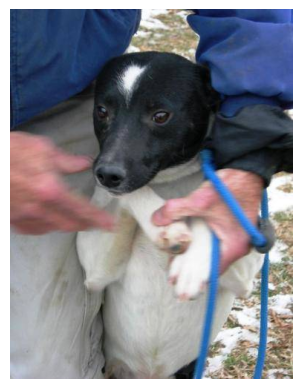

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
The image is classified as a Dog


In [7]:
import os
import numpy as np
import cv2
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

# Load the trained SVM model and scaler
svm = joblib.load('svm_vgg16_dogs_vs_cats.pkl')
scaler = joblib.load('scaler.pkl')

# Load VGG16 model without the top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def load_and_preprocess_image(image_path, image_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, image_size)
        img = preprocess_input(img)
        return img
    else:
        raise ValueError("Image not found or unable to read.")

def extract_features(image):
    image = np.expand_dims(image, axis=0)
    features = vgg_model.predict(image)
    features = features.reshape((features.shape[0], -1))
    return features

def classify_image(image_path):
    image = load_and_preprocess_image(image_path)
    
    # Display the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    # Extract features
    features = extract_features(image)
    
    # Scale the features
    features = scaler.transform(features)
    
    # Predict using the SVM model
    prediction = svm.predict(features)
    
    # Return the result
    if prediction == 0:
        return "Cat"
    else:
        return "Dog"

# Example usage
image_path = '/kaggle/input/dogs-vs-cats/test1/test1/1.jpg'
result = classify_image(image_path)
print(f'The image is classified as a {result}')
